# Demo of End-to-End Time Domain Audio with fastai

fastaudio focuses on spectrograms. `fastai` use cases tend to focus on classification. We need to go beyond those. Instead we'll focus on two things:

1. autoregressive prediction in the time domain. We'll use an LSTM -- essentially adapting the language model lessons

2.  audio-to-audio processing/translation (e.g. audio effects). We'll use stacked 1D convolutions like a U-Net

(you probably noticed already that task #1 could be in task #2, for the case of translating to audio shifted ahead by one sample.)

#### "How many channels of audio are we going to use?"
 That's up to the dataset!  We'll try our best to assume that it's just mono.

#### "What other fastai datatypes/projects are relevant?"
 There are three packages that are relevant for sequence modeling:

1.  `fastaudio`, as we mentioned, is only for spectrogram classification. The `AudioBlock` makes batches using an entire audio file which then gets converted to spectrograms.  Instead, we want to progressively grab sequences of audio samples and as (uniform-length) chunks.

2. The [Time Series Prediction](https://timeseriesai.github.io/tsai/) package is relevant, but the only time series output it seems to support is ["univariate forecasting"](https://timeseriesai.github.io/tsai/#Univariate-Forecasting).  Nope. 
3. Language Modeling, e.g. Chapters [10](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) and [12](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb) from fastbook. Yea, that's the closest. We can treat the audio samples as if they were word vectors/embeddings: just make the tokenizer and numericalize methods to be no-ops (or we could use mu-law encoding).  Nice thing is the dimensionality of the embeddings is just equal to how many channels of audio you have. 
   
We'll use *some* of fastaudio but we'll also liberally rewrite/overwrite whatever we want. We'll start with their imports..  

In [ ]:
#hide
# If on Colab, uncomment & run the next line, then restart:
#! [ -e /content ] && pip install -Uqq fastai git+https://github.com/drscotthawley/fastproaudio.git 

In [ ]:
#all_slow

In [ ]:
# Additional installs beyond fastai and fastproaudio
#%pip install -Uq pip fastai fastai_minima wheel torchsummary pyzenodo3 wandb

# Installing from GitHub can take a little while BTW...
#%pip install -q wheel git+https://github.com/csteinmetz1/micro-tcn.git  git+https://github.com/csteinmetz1/auraloss

In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.callback.fp16 import *
import wandb
from fastai.callback.wandb import *
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio 
import matplotlib.pyplot as plt
import torchsummary
from fastproaudio.core import *
from glob import glob
import json

use_fastaudio = False
if use_fastaudio:
    from fastaudio.core.all import *
    from fastaudio.augment.all import *
    from fastaudio.ci import skip_if_ci

## Possible Datasets and Tasks

As for data, we just use the fastaudio "speakers" dataset for now:

In [ ]:
#URLs.SPEAKERS10 = "http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz"
#path = untar_data(URLs.SPEAKERS10)

....and then we could learn some kind of inverse effect such as denoising: we could add noise to the audio files and then train the network to remove the noise. 

But what other audio datasets are available? 

* [torchaudio datasets](https://pytorch.org/audio/stable/datasets.html). These are almost all about speech; only GTZAN is musical.  
* I've got the [SignalTrain audio dataset for compressors](https://zenodo.org/record/3824876) although it's 20 GB. 
* [Source separation datasets](https://source-separation.github.io/tutorial/data/datasets.html), i.e. mono-to-many
* [ISMIR has a list of datasets](https://ismir.net/resources/datasets/)
* We can always grab audio and then use Spotify's new [Pedalboard](https://github.com/spotify/pedalboard) to add effects
* [Marco Martinez' Leslie effects dataset](https://zenodo.org/record/3562442) is a bit less than 1 GB. It has "dry" (input) and "tremelo" (target) directories.

## My Choice&#58; Reproduce Micro-TCN

I'll choose the task of reproducing Christian Steinmetz's [Micro-TCN](https://github.com/csteinmetz1/micro-tcn) work for learning audio compressors. And rather than use the full 20 GB SignalTrain dataset, let's use the 200MB "Reduced" dataset I just made. It's only the first 10 seconds of each 20-minute audio file, but it's enough for a reasonably-quick demo. 

### Download and Inspect the Data

In [ ]:
path = get_audio_data(URLs.SIGNALTRAIN_LA2A_REDUCED); path

Path('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced')

Steinmetz uses PyTorch Lightning instead of fastai.  We should be able to do the bare minimum integration by following [Zach Mueller's prescription](https://muellerzr.github.io/fastblog/2021/02/14/Pytorchtofastai.html). 

First let's take a look:

In [ ]:
fnames_in = sorted(glob(str(path)+'/*/input*'))
fnames_targ = sorted(glob(str(path)+'/*/*targ*'))
ind = -1   # pick one spot in the list of files
fnames_in[ind], fnames_targ[ind]

('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced/Val/input_260_.wav',
 '/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced/Val/target_260_LA2A_2c__1__85.wav')

**Input audio:**

Shape: (1, 441000), Dtype: torch.float32, Duration: 10.0 s
Max:  0.225,  Min: -0.218, Mean:  0.000, Std Dev:  0.038


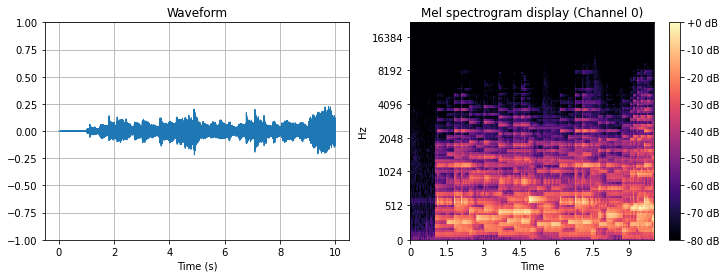

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)   # turn off annoying matplotlib warnings

waveform, sample_rate = torchaudio.load(fnames_in[ind])
show_audio(waveform, sample_rate)

**Target output audio:**

Shape: (1, 441000), Dtype: torch.float32, Duration: 10.0 s
Max:  0.091,  Min: -0.103, Mean: -0.000, Std Dev:  0.021


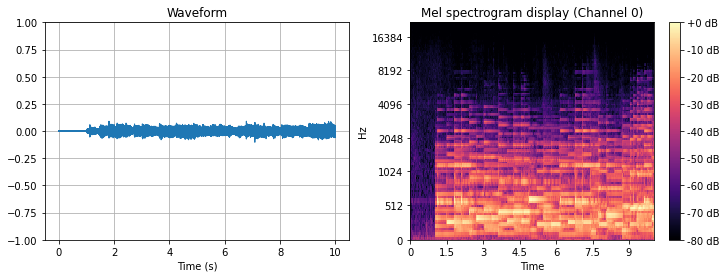

In [ ]:
target, sr_targ = torchaudio.load(fnames_targ[ind])
show_audio(target, sr_targ)

Let's look at the difference.

**Difference:**

Shape: (1, 441000), Dtype: torch.float32, Duration: 10.0 s
Max:  0.144,  Min: -0.159, Mean: -0.000, Std Dev:  0.018


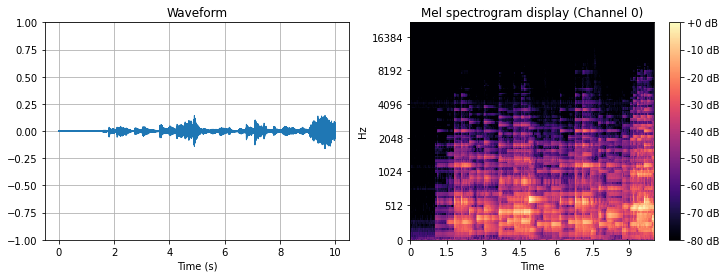

In [ ]:
show_audio(target - waveform, sample_rate)

### Import Steinmetz's (PyTorch-Lighting) Code (and make it work with fastai)

In [ ]:
#%pip install -q wheel git+https://github.com/csteinmetz1/micro-tcn.git  git+https://github.com/csteinmetz1/auraloss

**Datasets and Dataloader definitions:** These use Christian's custom [SignalTrainLA2ADataset](https://github.com/csteinmetz1/micro-tcn/blob/6f2c9a8da33590bdc496b8ea7aee4f268ee8da14/microtcn/data.py#L10) class.  Each Dataset object returns 3 items from `__getitem__()`: `input`, `target`, and `params`.  To make our lives easier with fastai, we're going to "pack" the `input` and the `params` together with our own subclassed Dataset, then we'll have the model unpack them later.

In [ ]:
from microtcn.data import SignalTrainLA2ADataset

class SignalTrainLA2ADataset_fastai(SignalTrainLA2ADataset):
    "For fastai's sake, have getitem pack the inputs and params together"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __getitem__(self, idx):
        input, target, params = super().__getitem__(idx)
        return torch.cat((input,params),dim=-1), target   # pack input and params together

In [ ]:
class Args(object):  # stand-in for parseargs 
    model_type ='tcn'
    root_dir = str(path)
    preload = False
    sample_rate = 44100
    shuffle = True
    train_subset = 'train'
    val_subset = 'val'
    train_length = 65536
    train_fraction = 1.0
    eval_length = 131072
    batch_size = 8   # original is 32, my laptop needs smaller
    num_workers = 4
    precision = 32
    n_params = 2
    
args = Args()

#if args.precision == 16:  torch.set_default_dtype(torch.float16)

# setup the dataloaders
train_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    subset=args.train_subset, 
                    fraction=args.train_fraction,
                    half=True if args.precision == 16 else False, 
                    preload=args.preload, 
                    length=args.train_length)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                    shuffle=args.shuffle,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

val_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    preload=args.preload,
                    half=True if args.precision == 16 else False,
                    subset=args.val_subset,
                    length=args.eval_length)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

[(0.0, 0.0), (0.0, 5.0), (0.0, 15.0), (0.0, 20.0), (0.0, 25.0), (0.0, 30.0), (0.0, 35.0), (0.0, 40.0), (0.0, 45.0), (0.0, 55.0), (0.0, 60.0), (0.0, 65.0), (0.0, 70.0), (0.0, 75.0), (0.0, 80.0), (0.0, 85.0), (0.0, 90.0), (0.0, 95.0), (0.0, 100.0), (1.0, 0.0), (1.0, 5.0), (1.0, 15.0), (1.0, 20.0), (1.0, 25.0), (1.0, 30.0), (1.0, 35.0), (1.0, 40.0), (1.0, 45.0), (1.0, 50.0), (1.0, 55.0), (1.0, 60.0), (1.0, 65.0), (1.0, 75.0), (1.0, 80.0), (1.0, 85.0), (1.0, 90.0), (1.0, 95.0), (1.0, 100.0)]
Total Examples: 396     Total classes: 38
Fraction examples: 396    Examples/class: 10
Training with 0.25 min per class    Total of 9.41 min
Located 380 examples totaling 9.41 min in the train subset.
Located 45 examples totaling 2.23 min in the val subset.


If the user requested fp16 precision then we need to install NVIDIA apex:

In [ ]:
if False and args.precision == 16:
    %pip install -q --disable-pip-version-check --no-cache-dir git+https://github.com/NVIDIA/apex
    from apex.fp16_utils import convert_network

### Define the model(s)
Christian defined a lot of models. We'll do the TCN-300 ~~and the LSTM~~. 

In [ ]:
from microtcn.tcn_bare import TCNModel as TCNModel
#from microtcn.lstm import LSTMModel # actually the LSTM depends on a lot of Lightning stuff, so we'll skip that
from microtcn.utils import center_crop, causal_crop


class TCNModel_fastai(TCNModel):
    "For fastai's sake, unpack the inputs and params"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, x, p=None):
        if (p is None) and (self.nparams > 0):  # unpack the params if needed
            assert len(list(x.size())) == 3   # sanity check 
            x, p = x[:,:,0:-self.nparams], x[:,:,-self.nparams:]
        return super().forward(x, p=p)

In [ ]:
train_configs = [
      {"name" : "TCN-300",
     "model_type" : "tcn",
     "nblocks" : 10,
     "dilation_growth" : 2,
     "kernel_size" : 15,
     "causal" : False,
     "train_fraction" : 1.00,
     "batch_size" : args.batch_size
    }
]

ind = 0
dict_args = train_configs[ind]
dict_args["nparams"] = 2

model = TCNModel_fastai(**dict_args)
dtype = torch.float32

Let's take a look at the model:

In [ ]:
if type(model) == TCNModel_fastai:
    torchsummary.summary(model, [(1,args.train_length)], device="cpu")
else:
    torchsummary.summary(model, [(1,args.train_length),(1,2)], device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]              48
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 32]             544
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 32]           1,056
              ReLU-6                [-1, 1, 32]               0
            Conv1d-7            [-1, 32, 65520]             480
            Linear-8                [-1, 1, 64]           2,112
       BatchNorm1d-9            [-1, 32, 65520]               0
             FiLM-10            [-1, 32, 65520]               0
            PReLU-11            [-1, 32, 65520]              32
           Conv1d-12            [-1, 32, 65534]              32
         TCNBlock-13            [-1, 32, 65520]               0
           Conv1d-14            [-1, 32

### Getting the model into fastai form

Zach Mueller made a very helpful [fastai_minima](https://muellerzr.github.io/fastai_minima/) package that we'll use, and follow his instructions.

In [ ]:
from torch import optim
from fastai_minima.optimizer import OptimWrapper
#from fastai_minima.learner import Learner  # this doesn't include lr_find()
from fastai.learner import Learner
from fastai_minima.learner import DataLoaders
from fastai_minima.callback.training_utils import CudaCallback, ProgressCallback

In [ ]:
def opt_func(params, **kwargs): return OptimWrapper(optim.SGD(params, **kwargs))

dls = DataLoaders(train_dataloader, val_dataloader)

### Checking: Let's make sure the Dataloaders are working

In [ ]:
if args.precision==16: 
    dtype = torch.float16
    model = convert_network(model, torch.float16)

model = model.to('cuda:0')
if type(model) == TCNModel_fastai:
    print("We're using Hawley's modified code")
    packed, targ = dls.one_batch()
    inp, params = packed[:,:,0:-dict_args['nparams']], packed[:,:,-dict_args['nparams']:]
    pred = model.forward(packed.to('cuda:0', dtype=dtype))
else:
    print("We're using Christian's version of Dataloader and model")
    inp, targ, params = dls.one_batch()
    pred = model.forward(inp.to('cuda:0',dtype=dtype), p=params.to('cuda:0', dtype=dtype))
print(f"input  = {inp.size()}\ntarget = {targ.size()}\nparams = {params.size()}\npred   = {pred.size()}")
#assert pred.size() == targ.size()

We're using Hawley's modified code
input  = torch.Size([8, 1, 65536])
target = torch.Size([8, 1, 65536])
params = torch.Size([8, 1, 2])
pred   = torch.Size([8, 1, 51214])


We can make the pred and target the same when we evalualte the loss:

In [ ]:
class Crop_Loss:
    "Crop target size to match preds"
    def __init__(self, axis=-1, causal=False, reduction="mean", func=nn.L1Loss):
        store_attr()
        self.loss_func = func()
    def __call__(self, pred, targ):
        targ = causal_crop(targ, pred.shape[-1]) if self.causal else center_crop(targ, pred.shape[-1])
        #pred, targ = TensorBase(pred), TensorBase(targ)
        assert pred.shape == targ.shape, f'pred.shape = {pred.shape} but targ.shape = {targ.shape}'
        return self.loss_func(pred,targ).flatten().mean() if self.reduction == "mean" else loss(pred,targ).flatten().sum()
    

# and a metric
def crop_mse(pred, targ, causal=False): 
    targ = causal_crop(targ, pred.shape[-1]) if causal else center_crop(targ, pred.shape[-1])
    return ((pred - targ)**2).mean()

#### Enable logging with WandB:

In [ ]:
wandb.login()

True

### Define the model and callbacks
We're going to add a new custom WandBAudio callback futher below, that we'll uses when we call `fit()`.

#### WandBAudio Callback
In order to log audio samples, let's write our own audio-logging callback for fastai:

In [ ]:
class WandBAudio(Callback):
    """Progress-like callback: log audio to WandB"""
    order = ProgressCallback.order+1
    def __init__(self, n_preds=5, sample_rate=44100):
        store_attr()

    def after_epoch(self):  
        if not self.learn.training:
            with torch.no_grad():
                preds, targs = [x.detach().cpu().numpy().copy() for x in [self.learn.pred, self.learn.y]]
            log_dict = {}
            for i in range(min(self.n_preds, preds.shape[0])): # note wandb only supports mono
                    log_dict[f"preds_{i}"] = wandb.Audio(preds[i,0,:], caption=f"preds_{i}", sample_rate=self.sample_rate)
            wandb.log(log_dict)

In [ ]:
wandb.init(project='micro-tcn-fastai')#  no name, name=json.dumps(dict_args))

learn = Learner(dls, model, loss_func=Crop_Loss(), metrics=crop_mse, opt_func=opt_func,
               cbs= [MixedPrecision(),FP16TestCallback(),CudaCallback(),WandbCallback()])

### Train the model!

SuggestedLRs(valley=0.0009120108443312347)

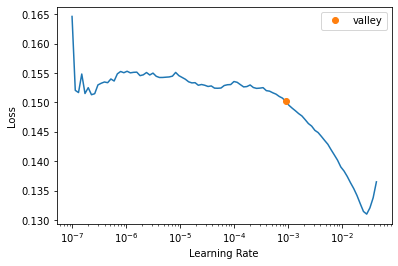

In [ ]:
learn.lr_find(end_lr=0.1) 

In [ ]:
learn.fit_one_cycle(30, lr_max=2e-3, cbs=WandBAudio(sample_rate=args.sample_rate))

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 


epoch,train_loss,valid_loss,crop_mse,time
0,0.120726,0.055666,0.005076,00:05
1,0.092558,0.057605,0.008518,00:05
2,0.069566,0.045256,0.005685,00:05
3,0.052715,0.036558,0.003950,00:05
4,0.041022,0.030866,0.003125,00:05
5,0.034007,0.024389,0.002031,00:05
6,0.029066,0.023266,0.002034,00:05
7,0.025302,0.020324,0.001462,00:05
8,0.023012,0.018916,0.001290,00:05
9,0.020824,0.019834,0.001323,00:05


In [ ]:
wandb.finish()

crop_mse,▅█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dampening_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
nesterov_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▇▅▄▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train_loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▅▄▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
crop_mse,0.00044


In [ ]:
learn.save('micro-tcn-fastai')

Path('models/micro-tcn-fastai.pth')

Go check out the resulting run logs, graphs, and audio samples at https://wandb.ai/drscotthawley/micro-tcn-fastai